# Introduction

This project works on the  Uniform Crime Reporting (UCR) Statistics in Houston. The original raw data is available from http://www.houstontx.gov/police/cs/index-2.htm. The UCR data contained in these reports, is presented in a monthly breakdown of Part I crimes for which HPD wrote police reports. The data is furthered broken down by police districts and beats and shows reports of the following types of crimes:  murder, rape, robbery, aggravated assault, burglary, theft, auto theft. More information can be found [here](http://www.houstontx.gov/police/cs/index-2.htm). We use spreadsheets for the year 2010-2017 for our project.

# Load the data
We save all 96 spreadsheets in the computer. Since most spreadsheets have 10 columns: 'Date', 'Hour', 'Offense Type', 'Beat', 'Premise', 'Block Range', 'Street Name',
 'Type,' 'Suffix', '# Of Offenses' with some of them having alias. We first check if all spreadsheets have 10 columns and if all columns are in the same order before stacking them into one big dataframe. 

In [1]:
import glob
 # Write the pattern: pattern
pattern = '/Users/phyhouhou/Downloads/Houston crime statistics data/*.xls'
 # Save filenames
files = glob.glob(pattern)
len(files)


96

In [2]:
import pandas as pd

# Produce the file names in a chronological order
import calendar
files=['/Users/phyhouhou/Downloads/Houston crime statistics data/'+str(calendar.month_abbr[i]).lower()+str(j)+'.xls' for j in range(10,18) for i in range(1,13) ]

# Take record for files, information includes: filename, number of columns, column names
record=pd.DataFrame(columns=['file','num_col','colnames'])
for file in files:
    df=pd.read_excel(file)
    record=record.append({'file':file[-9:],'num_col':len(df.columns),'colnames':df.columns.values},ignore_index=True)

WARNING *** file size (2752234) not 512 + multiple of sector size (512)
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** file size (3078551) not 512 + multiple of sector size (512)
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero


## Problems
From the record we spot the problems below:<br>
1. jun14.xls and jul14.xls has 9 cols with 'Premise' missing

2. jan10.xls, nov10.xls,jul13.xls has extra col: 'Unnamed: 1; sep10.xls has an extra col: 'Field11'

3. Different names used for some columns

In [3]:
print('column names:',record.colnames[1])

record_col_missing=record[record.num_col<10]
print('\n', record_col_missing)

record_col_extra=record[record.num_col>10];
print('\n', record_col_extra)



column names: ['Date' 'Hour' 'Offense Type' 'Beat' 'Premise' 'Block Range' 'Street Name'
 'Type' 'Suffix' '# Of Offenses']

          file  num_col                                           colnames
53  jun14.xls      9.0  [Date, Hour, Offense Type, Beat, Block Range, ...
54  jul14.xls      9.0  [Date, Hour, Offense Type, Beat, Block Range, ...

          file  num_col                                           colnames
0   jan10.xls     11.0  [Date, Unnamed: 1, Hour, Offense Type, Beat, P...
8   sep10.xls     11.0  [Date, Hour, Offense Type, Beat, Premise, Bloc...
10  nov10.xls     11.0  [Date, Unnamed: 1, Hour, Offense Type, Beat, P...
42  jul13.xls     11.0  [Date, Unnamed: 1, Hour, Offense Type, Beat, P...


## Solutions
### How to deal with extra/missing cols?
We find that all extral columns are empty. So let's drop them. We fill missing columns with 'UNK' so far. Later we will check the proportion of nan and make decisions then.

In [4]:
# Check whether extra columns in some files are empty
file_extra=['jan10.xls','sep10.xls','nov10.xls','jul13.xls']
res=[ ]
for file in file_extra:
    fn='/Users/phyhouhou/Downloads/Houston crime statistics data/'+file
    df=pd.read_excel(fn)
    if (file!='sep10.xls'):
        res.append(df['Unnamed: 1'].isnull().values.all()) 
    else:
        res.append(df['Field11'].isnull().values.all())
print(res)

WARNING *** file size (2752234) not 512 + multiple of sector size (512)
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
[True, True, True, True]


 First fix columns such that all files have 10 columns.

In [5]:
import calendar
files=['/Users/phyhouhou/Downloads/Houston crime statistics data/'+str(calendar.month_abbr[i]).lower()+str(j)+'.xls' for j in range(10,18) for i in range(1,13) ]

# Take record of information for files
record=pd.DataFrame(columns=['file','num_col','colnames'])
for file in files:
    df=pd.read_excel(file)
    if(len(df.columns)<10):
         df.insert(4,'Premise','UNK')
    elif(len(df.columns)>10):
         df.dropna(axis=1,how='all',inplace=True)
    

    record=record.append({'file':file[-9:],'num_col':len(df.columns),'colnames':df.columns.values},ignore_index=True)

WARNING *** file size (2752234) not 512 + multiple of sector size (512)
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** file size (3078551) not 512 + multiple of sector size (512)
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero


### Columns have variant names in different order?
Now check the order of columns. We find that the order of columns is the same except that some colnames need to be cleaned. So let's rename the columns. 

In [6]:
col_order=pd.DataFrame.from_items(zip(record.colnames.index, record.colnames.values)).T
[ set(col_order[i]) for i in range(10)]


[{'Date'},
 {'Hour'},
 {'Offense Type'},
 {'Beat'},
 {'Premise'},
 {'Block Range', 'BlockRange'},
 {'Street Name', 'StreetName'},
 {'Type'},
 {'Suffix'},
 {'# Of', '# Of Offenses', '# Offenses', '# offenses', 'Offenses'}]

## Merge and explore the raw data 

In [7]:
import calendar
files=['/Users/phyhouhou/Downloads/Houston crime statistics data/'+str(calendar.month_abbr[i]).lower()+str(j)+'.xls' for j in range(10,18) for i in range(1,13) ]

import pandas as pd

dfs=[]
for file in files:
    
    df=pd.read_excel(file)
    
    if(len(df.columns)<10):
        df.insert(4,'Premise','UNK')
    elif(len(df.columns)>10):
        df.dropna(axis=1,how='all',inplace=True)
    
    df.columns=['Date', 'Hour', 'OffenseType', 'Beat', 'Premise', 'BlockRange',
       'StreetName', 'Type', 'Suffix', 'OffenseNum']
    df['Date']=pd.to_datetime(df['Date'])
    
    dfs.append(df)

# Concatenate frames into a single DataFrame: crimes
crimes = pd.concat(dfs,ignore_index=True)

# Save crimes into a csv file
crimes.to_csv('crimes.csv',index=False)#,na_rep="UNK"

WARNING *** file size (2752234) not 512 + multiple of sector size (512)
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** file size (3078551) not 512 + multiple of sector size (512)
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero


In [35]:
# Load data
import pandas as pd
crimes=pd.read_csv('crimes.csv',low_memory=False,keep_default_na=True,na_values=['UNK'])

In [36]:
#Randomly select 5 observations
crimes.sample(n=5)

,Date,Hour,OffenseType,Beat,Premise,BlockRange,StreetName,Type,Suffix,OffenseNum
567114,2014-05-06,0,Theft,19G30,20D,4500-4599,COOK,RD,-,1.0
180642,2011-05-24,12,Theft,20G50,080,900-999,GESSNER,DR,-,1.0
530741,2014-01-26,16,Theft,19G40,20R,12700-12799,SHANNON HILLS,DR,-,1.0
519262,2013-11-24,14,Theft,20G40,20R,2000-2099,BENTWORTH,DR,-,1.0
548362,2014-03-31,12,Theft,20G80,240,1000-1099,WEST OAKS MALL,-,-,1.0


In [37]:
crimes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1006331 entries, 0 to 1006330
Data columns (total 10 columns):
Date           1006326 non-null object
Hour           1006330 non-null object
OffenseType    1006330 non-null object
Beat           1003191 non-null object
Premise        972734 non-null object
BlockRange     1000767 non-null object
StreetName     1006323 non-null object
Type           1006330 non-null object
Suffix         1006330 non-null object
OffenseNum     1006330 non-null float64
dtypes: float64(1), object(9)
memory usage: 76.8+ MB


In [38]:
crimes.OffenseNum.describe()

count    1.006330e+06
mean     1.015497e+00
std      1.636272e-01
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      3.300000e+01
Name: OffenseNum, dtype: float64

In [39]:
for col in crimes.columns.values[:-1]:
    print(col,': ',len(crimes[col].value_counts()))

Date :  3910
Hour :  83
OffenseType :  16
Beat :  354
Premise :  384
BlockRange :  346
StreetName :  27793
Type :  53
Suffix :  5


In [40]:
from datetime import date

d0 = date(2010, 1, 1)
d1 = date(2017, 12, 31)
delta = d1 - d0
print (delta.days)


2921


### A short summary of data
The dimension of crimes dataframe is (1006331,10) with most of columns having missing values. We need to calculate the missing proportion and decide how to take care of the the missing values. 

The data types are not clear, indicating it might be a mixture of multiple data types. For the numeric column 'OffenseNum', it seems that max is quite larger than other quantiles indicating it might be an outlier? 

Concerning the categorical columns, it looks quite messy. Take the 'Date' column for example, relevant date should be from '2010-01-01' to '2017-12-31', which is 2921 days together but the crimes data has much more than that. Take the 'Hour' column for example, it should be from 0 to 23 at most but the crimes data gives a set of 83 hour types.

## Processing missing data

In [41]:
#Count number of NaN's in each column
crimes.isnull().sum() 

Date               5
Hour               1
OffenseType        1
Beat            3140
Premise        33597
BlockRange      5564
StreetName         8
Type               1
Suffix             1
OffenseNum         1
dtype: int64

###  Drop empty rows 

In [42]:
crimes.dropna(axis=0,how='all',inplace=True)

### Drop rows where 'Date' is NaN since it's a low proportion and no idea how to fillnas

In [43]:
crimes.dropna(subset=['Date'],inplace=True)

### Calculate proportion of NaN

In [44]:
prop_na=pd.DataFrame(crimes.isnull().sum()/crimes.shape[0]).T
prop_na

,Date,Hour,OffenseType,Beat,Premise,BlockRange,StreetName,Type,Suffix,OffenseNum
0,0.0,0.0,0.0,0.003119,0.033381,0.005528,0.000007,0.0,0.0,0.0


### Fill NaN with 'UNK'
Since columns with missing data are object type, we fill NaN with 'UNK'.

In [45]:
crimes.fillna('UNK',axis=1,inplace=True)
crimes.isnull().sum()

Date           0
Hour           0
OffenseType    0
Beat           0
Premise        0
BlockRange     0
StreetName     0
Type           0
Suffix         0
OffenseNum     0
dtype: int64

## Clean data types

In [19]:
crimes.dtypes

Date            object
Hour            object
OffenseType     object
Beat            object
Premise         object
BlockRange      object
StreetName      object
Type            object
Suffix          object
OffenseNum     float64
dtype: object

A short summary after setting the string columns:<br>
1. Note that when 'Hour' contains "'", corresponding 'Beat' contains "'". So let's remove "'"
2. Note that 'OffenseType' contains type '1'. This is ambiguous. Remove?
3. Note that 'Premise' contains code or word. Need to map via dictionary!
4. Note that 'BlockRange' contains '1.1103e+006-1.1104e+006' Yes, in sep17 file
5. Note that 'OffenseNum' contains 33, 29, 17...really??? (seem so, related crime types: 'Aggravated Assault','Aggravated Assault ','Auto Theft','AutoTheft','Burglary','Theft') outliers?

### Clean 'Date' column

In [46]:
crimes.Date=pd.to_datetime(crimes.Date)

In [51]:
#crimes.Date.dt.year.unique()
crimes.Date.dt.year.value_counts().head(15)

2010    136357
2013    130200
2012    127486
2011    127168
2016    122423
2014    121451
2015    120079
2017    118581
2009      1596
2008       195
2001       146
2007       109
2005        98
2006        87
2000        56
Name: Date, dtype: int64

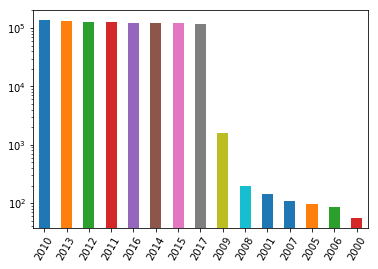

In [52]:
import matplotlib.pyplot as plt
crimes.Date.dt.year.value_counts()[:15].plot(kind='bar',logy=True,rot=60)#value_counts(normalize=True)
plt.show()

As shown in the previous graph, there are years outside the range of '2010'-'2017'. We keep data with years in the range only.

In [53]:
crimes=crimes[(crimes.Date>='2010')&(crimes.Date<'2018')]
crimes.sort_values(by='Date',inplace=True) 

#crimes.insert(1,'Year',crimes['Date'].dt.year.astype('category'))
#crimes.insert(2,'Month',crimes['Date'].dt.month.astype('category'))
#crimes.insert(3,'Weekday',crimes['Date'].dt.weekday_name.astype('category'))

### Clean 'Hour' column
We find that some Hour has a leading "'" and some has trailing ".0". We remove them and convert to categorical type. We unify '0' with '24' as '0'.

In [25]:
# Count types of Hour
#set(crimes.Hour)

In [54]:
# Remove "'" and ".0"
crimes.Hour=crimes.Hour.str.translate(str.maketrans({"'":None})).astype(float).astype(int).astype('category')#.astype(int)

# Replace 24 with 0
crimes.Hour.replace(24,0,inplace=True)

len(set(crimes.Hour))
#set(crimes.Hour)

24

### Clean and recode 'OffenseType' column
We need to move trailing whitespaces and we will move spaces between words.

In [55]:
set(crimes.OffenseType)

{'1',
 'Aggravated Assault',
 'Aggravated Assault       ',
 'Auto Theft',
 'AutoTheft',
 'AutoTheft                ',
 'Burglary',
 'Burglary                 ',
 'Murder',
 'Murder                   ',
 'Rape',
 'Rape                     ',
 'Robbery',
 'Robbery                  ',
 'Theft',
 'Theft                    '}

In [56]:
# Clean the offense types by removing trailing whitespaces and spaces inbetween words
crimes.OffenseType=crimes.OffenseType.str.strip().replace('\s+','',regex=True)#.astype('category')
crimes.OffenseType.value_counts(normalize=True)

Theft                0.550739
Burglary             0.181179
AutoTheft            0.100354
AggravatedAssault    0.082556
Robbery              0.076426
Rape                 0.006835
Murder               0.001896
1                    0.000014
Name: OffenseType, dtype: float64

There is an unknow type of crimes '1', which has only a small portion 0.0013%. We just remove it.

In [57]:
# Remove offensetype='1'
crimes=crimes[crimes.OffenseType!='1']
crimes.groupby('OffenseType').size().sort_values(ascending=False)

OffenseType
Theft                552802
Burglary             181858
AutoTheft            100730
AggravatedAssault     82865
Robbery               76712
Rape                   6861
Murder                 1903
dtype: int64

### Clean 'Beat'


In [58]:
# Remove "'" 
crimes.Beat=crimes.Beat.str.translate(str.maketrans({"'":None}))
# Remove whitespaces
crimes.Beat=crimes.Beat.str.strip()
#set(crimes.Beat)
crimes.Beat.value_counts(normalize=True)['UNK']

0.003176149785151599

The beat 'UNK' representing missing values takes a portion of 0.032%. Shall we remove all rows containing it or keep it???

### Clean 'Premise' column

The 'Premise' column is a mixture of premise type and premise description. The plan is to convert description ino code according to the (HPD table)[http://www.houstontx.gov/police/cs/beatpages/premise.htm#]. However both the table and the 'Premise' column are messy, making looking up a dictionary very difficult. Since the premise data is expected to play an important role in predicting crime types, we wish to keep as much information as possible. We need a better plan. 

First, translate the HPD Premise table into a reduced dictionary by keeping only the first two digits in the premise type. This largely reduces the variaties of premise types (from 126 to 25).  This might lose some information but the reason to do this is that if we keep lots of types, then more data are required to train and it's hard for the model to learn. 

Then we convert descriptions in 'Premise' column by looking up the reduced dictionary if it finds a match otherwise keep the description as is. Certainly there are descriptions not translated, we can do it manually by selecing dominant ones according to its frequencies.

In [59]:
#set(crimes.Premise)
# Remove whitespaces
crimes.Premise=crimes.Premise.str.strip().str.lower().str.replace(' or ','/')
set(crimes.Premise)

{'---',
 '01a',
 '01b',
 '01k',
 '01p',
 '01r',
 '01t',
 '02b',
 '02c',
 '02s',
 '02v',
 '03b',
 '03s',
 '040',
 '04v',
 '05a',
 '05b',
 '05c',
 '05d',
 '05e',
 '05f',
 '05g',
 '05h',
 '05l',
 '05m',
 '05n',
 '05o',
 '05p',
 '05q',
 '05r',
 '05s',
 '05t',
 '05u',
 '05v',
 '05w',
 '05x',
 '05y',
 '05z',
 '06',
 '060',
 '070',
 '080',
 '09d',
 '09h',
 '09p',
 '09r',
 '09v',
 '100',
 '11c',
 '11f',
 '11g',
 '11l',
 '11p',
 '11r',
 '11s',
 '11v',
 '120',
 '12v',
 '13a',
 '13b',
 '13c',
 '13h',
 '13r',
 '13s',
 '13t',
 '140',
 '14v',
 '150',
 '160',
 '170',
 '18a',
 '18b',
 '18c',
 '18d',
 '18g',
 '18h',
 '18l',
 '18m',
 '18n',
 '18o',
 '18p',
 '18r',
 '18s',
 '18t',
 '18u',
 '18w',
 '190',
 '19v',
 '20a',
 '20c',
 '20d',
 '20g',
 '20h',
 '20l',
 '20m',
 '20n',
 '20p',
 '20r',
 '20v',
 '20w',
 '210',
 '21v',
 '22c',
 '22d',
 '22e',
 '22h',
 '22m',
 '22p',
 '22u',
 '22v',
 '23c',
 '23s',
 '240',
 '24a',
 '24b',
 '24c',
 '24e',
 '24f',
 '24g',
 '24j',
 '24m',
 '24p',
 '24s',
 '24t',
 '24v',
 

In [60]:
# Download the Premise table from HPD
url='http://www.houstontx.gov/police/cs/beatpages/premise.htm#'
premise_hpd=pd.read_html(url,header=0)[0]

# Build a reduced dictionary: {'Premise Description': 'Premise Type'}
premise_dict=dict(zip(premise_hpd['Premise Description'].str.lower().str.replace('&','and'),
                      premise_hpd['Premise Type'].apply(lambda x: x[0:2])))


# First translate the parts that can be found in the premise_hpd dictionary
crimes.Premise=crimes.Premise.apply(lambda x: premise_dict[x] if x in premise_dict else x )

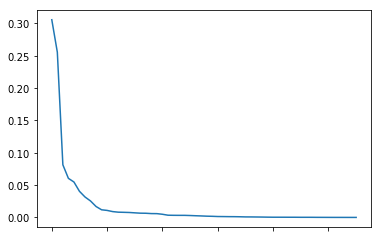

In [62]:
# Plot proportion of those not the form of two digits
mask=crimes.Premise.str.contains('\d{2}')
crimes[~mask].Premise.value_counts(dropna=False,normalize=True).plot()
plt.show()

In [63]:
len(set(crimes[~mask].Premise))#.value_counts()

56

In [64]:
crimes[~mask].Premise.value_counts(normalize=True)[:30]

road, street,/sidewalk                        0.305602
unk                                           0.255469
miscellaneous business (non-specific)         0.081380
grocery store/supermarket                     0.060397
other, unknown,/not listed                    0.054759
grocery store/supermarket parking lot         0.040358
hotel, motel, inn, etc.                       0.031612
parks and recreation, zoo, swimming pool      0.025402
---                                           0.016869
vacant single occ resd(house,townhs,dplex)    0.011794
gym, recreat, club house, indoor pool, spa    0.010827
church, synagogue,/temple                     0.009013
electronics store, electrical supplies        0.008114
church, synagogue,/temple parking lot         0.007893
field, woods, forest, park                    0.007634
apartment rental office                       0.007086
multi-plex home (duplex,triplex etc.)         0.006560
pawn, resale shop,/flea market                0.006438
bank/savin

HPD table has code '250' for unknown premise. Shall we distinguish it from missing premise?

In [65]:
replacements = {
   'road, street,/sidewalk':'13',
   'miscellaneous business (non-specific)':'05',
   'grocery store/supermarket':'12',
   'grocery store/supermarket parking lot':'18',
   'hotel, motel, inn, etc.':'14',
   'parks and recreation, zoo, swimming pool':'11',
   'vacant single occ resd(house,townhs,dplex)':'20',
   'gym, recreat, club house, indoor pool, spa':'05',
   'church, synagogue,/temple':'04',
    'electronics store, electrical supplies':'24',
    'church, synagogue,/temple parking lot':'18',
    'field, woods, forest, park':'10' ,
    'apartment rental office':'05',
    'multi-plex home (duplex,triplex etc.)':'20',
    'pawn, resale shop,/flea market':'24',
    'bank/savings institution parking lot':'18',
    'laundry, dry cleaners, washaterias':'05',
    "physician, doctor, dentist's office":'09',
    'stadium, sports arena, race track':'05',
    'gym, recreat, club house, indoor pool':'05',
    'factory, manufacturing,/industrial': '05',     
    'vacant other residential (apartment,dorms)':'20',
    'theatres, dinner theaters, auditoriums': '05', 
    'vacant storage fac (barn,garage,warehouse)' : '19',
    'daycare, child care,/kindergarten': '22',
    'amusement park, bowling alley, skate rink': '05',
    'furniture, appliances, radios, tv store': '24'
    
}
crimes.Premise.replace(replacements, inplace=True)


# First cut and keep only the first two character
crimes.Premise=crimes.Premise.apply(lambda x: x[0:2])

# Define a function to replace nondigit with '25'
def func(x):
    if not str(x).isdigit():
        #res='UNK'
        res='25'#UNK'
    else:
        res=x
    return res

#25	OTHER/UNKNOWN!!!!

crimes.Premise=crimes.Premise.apply(lambda x: func(x))


set(crimes.Premise)

{'01',
 '02',
 '03',
 '04',
 '05',
 '06',
 '07',
 '08',
 '09',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25'}

### Clean columns: 'Type', 'Suffix','OffenseNum'

In [66]:
crimes.Type=crimes.Type.str.strip()
crimes.Suffix=crimes.Suffix.astype('category')
crimes.OffenseNum=crimes.OffenseNum.astype(int)

## Drop duplicates

In [67]:
#crimes.duplicated().sum()
#crimes[crimes.duplicated(keep=False)]
crimes.drop_duplicates(keep='first',inplace=True)

## Reset index

In [68]:
crimes.reset_index(drop=True,inplace=True)

In [69]:
crimes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999521 entries, 0 to 999520
Data columns (total 10 columns):
Date           999521 non-null datetime64[ns]
Hour           999521 non-null category
OffenseType    999521 non-null object
Beat           999521 non-null object
Premise        999521 non-null object
BlockRange     999521 non-null object
StreetName     999521 non-null object
Type           999521 non-null object
Suffix         999521 non-null category
OffenseNum     999521 non-null int64
dtypes: category(2), datetime64[ns](1), int64(1), object(6)
memory usage: 62.9+ MB


## Save cleaned crimes into a csv file

In [70]:
crimes.to_csv('crimes_clean.csv',index=False)

In [2]:
import pandas as pd
crimes_clean=pd.read_csv('crimes_clean.csv')
crimes_clean.head()

,Date,Hour,OffenseType,Beat,Premise,BlockRange,StreetName,Type,Suffix,OffenseNum
0,2010-01-01,2,Theft,7C20,13,3100-3199,COLLINGSWORTH,-,-,1
1,2010-01-01,2,Robbery,20G70,18,1900-1999,WESTMEAD,DR,-,1
2,2010-01-01,9,Robbery,4F30,13,1700-1799,BRITTMOORE,RD,-,1
3,2010-01-01,10,Robbery,20G10,18,2900-2999,WEST SAM HOUSTON,PKWY,S,1
4,2010-01-01,14,Robbery,20G80,8,1000-1099,WEST OAKS MALL,-,-,1


## Append: adding columns 'Address', 'Latitude' and 'Longitude'

In this section, we add the column 'Address' by combining the 'StreetName' and 'Type' columns and then geocode the 'Address' columns to get corresponding latitudes and longtitudes of the addresses. This will help us to visualize the geographical visualiztion of the crime patterns/distributions and make better use of address information in machine learning. 

### Add columns Address

In [3]:
crimes_clean['Address']=crimes_clean['StreetName']+', '+crimes_clean['Type']
crimes_clean.head()

,Date,Hour,OffenseType,Beat,Premise,BlockRange,StreetName,Type,Suffix,OffenseNum,Address
0,2010-01-01,2,Theft,7C20,13,3100-3199,COLLINGSWORTH,-,-,1,"COLLINGSWORTH, -"
1,2010-01-01,2,Robbery,20G70,18,1900-1999,WESTMEAD,DR,-,1,"WESTMEAD, DR"
2,2010-01-01,9,Robbery,4F30,13,1700-1799,BRITTMOORE,RD,-,1,"BRITTMOORE, RD"
3,2010-01-01,10,Robbery,20G10,18,2900-2999,WEST SAM HOUSTON,PKWY,S,1,"WEST SAM HOUSTON, PKWY"
4,2010-01-01,14,Robbery,20G80,8,1000-1099,WEST OAKS MALL,-,-,1,"WEST OAKS MALL, -"


### Add column: Latitude, Longitude

We use the geocoders in geopy but receive the error 'GeocoderServiceError: HTTP Error 429: Too Many Requests'. How to solve this problem?

In [4]:
from geopy.geocoders import Nominatim
nom=Nominatim()
#crimes_clean['Coordinate']=crimes_clean['Address'].apply(nom.geocode)#slow
addr=crimes_clean['Address'].unique()
#addr_coor_dict=dict(zip(addr, pd.Series(addr).apply(nom.geocode).apply(lambda x: (x.latitude, x.longitude)))
#crimes_clean['Coordinate']=crimes_clean['Address'].map(addr_coor_dict)

In [5]:
# d_lat=dict(zip(addr, pd.Series(addr).apply(nom.geocode).apply(lambda x: x.latitude if x!=None else None)))
# crimes_clean['Latitude']=crimes_clean['Address'].map(d_lat)

# d_lon=dict(zip(addr, pd.Series(addr).apply(nom.geocode).apply(lambda x: x.longitude if x!=None else None))) 
# crimes_clean['Longitude']=crimes_clean['Address'].map(d_lon)

# HTTPERROR

In [ ]:
crimes_clean.head()